In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Bugs

"Bugs" are different than numerical errors. But I will discuss them here. There are two important classes of tests that can be used to find bugs in software. These are "unit" tests and "functional" tests. The differences between these can be illustrated by the example of the wifi in your home. You can test if the wifi is working by opening a browser on your computer and trying to get to google.com. That's a functional test. Or you can test the individual components: is your computer on? is its wifi enabled? does it find a connection? does it successfully connect to a different wifi network? is your router connected to power? is it on? is there a warning light on it? The functional test might work in some cases, but different problems are found in the unit tests (you get to google.com, but because the neighbor's wifi is on). Or the unit tests might all work but something not covered by them causes a failure (a Google outage). The unit tests will however help identify and diagnose problems that affect the function.

So "functional" tests are end-to-end tests of "is my code achieving its overall goals." This can be hard to determine for the problem that you are solving because generally you are doing the problem numerically because you do not know the answer. However there are some things that are helpful:

 * Testing how well certain conservation laws are maintained. For example, in the integration of differential equations, sometimes energy or momentum or other physical quantities are conserved. You can test how well they are conserved in the code to find if it is functioning correctly. However, it is important to understand that this depends on how precise you expect the code to be; that is, although it may be easy to find catastrophic failures, more subtle failures may escape your detection, because of the inherent round-off and approximation errors discussed below.
 
 * Performing a variation on the calculation whose answer you can determine analytically. E.g. if you have a 3D simulation, you can test a spherically symmetric case whose answer may be known. Again, you need to be aware that there still will be numerical errors.
 
"unit" tests are individual tests of the components of your code. For example, in the calculation of differential equations, there may be a complicated calculation involved as part of evaluating derivatives; that individual calculation might be the subject of a unit test. Or the integrator itself can be tested (using a simpler set of derivatives). 


As you see, many of the considerations around "bugs" are different for computation than for some other areas of computer science. Sorting a list or text search or integer constraint programming or other discrete operations have single well-defined answers, so testing is straightforward. In computation, many of the tests need to have a tolerance set by the round-off errors.

## Distribution of round-off errors

We can investigate what round-off errors look like by picking a bunch of random float64 values, recasting them as float32, and looking at the difference. This tells us the distribution of errors in float32 relative to the "right answer." Of course there are similar errors in float64 values, but of course much smaller.

Note we have to assume we are picking good random numbers. We'll talk later about how random numbers are actually generated.

In [2]:
values_64 = np.random.random(size=100000)
values_32 = np.float32(values_64)
diff = np.float64(values_32) - values_64

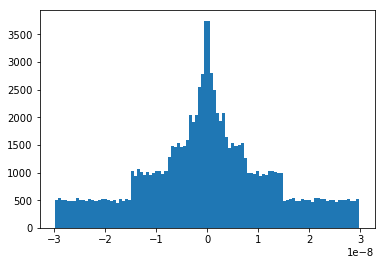

In [3]:
hist = plt.hist(diff, bins=100)

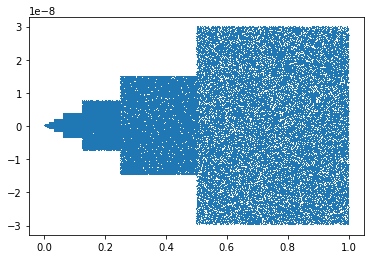

In [4]:
plt.plot(values_64, diff, ',')

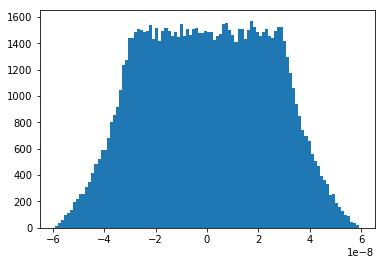

In [5]:
hist = plt.hist(diff / values_64, bins=100)

## Round-off vs. approximation errors

In [6]:
def fnc_int(limits=None):
    return ((limits[1]**3 - limits[0]**3) / 3. - 
            (limits[1]**4 - limits[0]**4) / 4. + 
            (limits[1]**5 - limits[0]**5) / 5.)

In [7]:
def fnc(x=None):
    return (x**2 - x**3 + x**4)

In [8]:
def integrate_fnc(limits=None, nstep=None, fnc=None, dtype=None):
    instep = 1. / np.float64(nstep).astype(dtype)
    step = (limits[1] - limits[0]) * instep 
    middles = limits[0] + (np.arange(nstep, dtype=dtype) + 0.5) * instep * (limits[1] - limits[0])
    values = fnc(middles)
    return (values.sum() * step)

In [9]:
dtype = np.float32

In [10]:
def test_integrate(dtype=None):
    limits = np.array([1., 2.], dtype=dtype)
    nstep_low = 10
    nstep_high = 100000000
    nnsteps = 50
    nsteps = 10.**(np.log10(nstep_low) +
                   (np.log10(nstep_high) - np.log10(nstep_low)) * np.arange(nnsteps) /
                   np.float64(nnsteps - 1))
    nsteps = np.int64(nsteps)
    error = np.zeros(nnsteps, dtype=np.float64)
    for indx in np.arange(nnsteps):
        integral = fnc_int(limits=np.float64(limits))
        approx = integrate_fnc(limits=limits, nstep=nsteps[indx], fnc=fnc, dtype=dtype)
        error[indx] = (approx - integral) / integral
    return(nsteps, error)

In [11]:
(nsteps64, error64) = test_integrate(dtype=np.float64)
(nsteps32, error32) = test_integrate(dtype=np.float32)

/Users/blanton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/blanton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 0, 'log$_{10}$ N$_{steps}$')

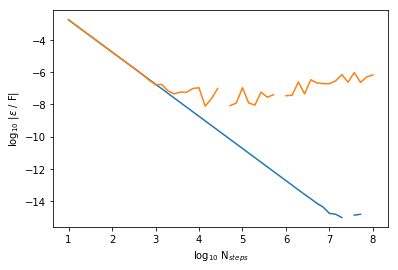

In [39]:
plt.plot(np.log10(nsteps64), np.log10(np.abs(error64)))
plt.plot(np.log10(nsteps32), np.log10(np.abs(error32)))
plt.ylabel('log$_{10}$ |$\epsilon$ / F|')
plt.xlabel('log$_{10}$ N$_{steps}$')

## Some tests

Below are some simple unit tests and a functional test of this case. In a regular piece of code, you would write the unit tests into a test file and call it with "pytest" or another standard utility, that you could then run every time you made a change to the code.

Note that for the unit tests, the round-off error isn't accounted for. These calculations are simple enough that they are evaluated exactly. This is a bit unsafe though!

In [40]:
def test_fnc():
    assert fnc(0.) == 0., "Failed 0"
    print("Passed 0")
    
    assert fnc(1.) == 1., "Failed 1."
    print("Passed 1")
    
    assert fnc(3.) == 63., "Failed 3."
    print("Passed 3")
    
    assert fnc(0.1) == 0.0091, "Failed 0.1"
    print("Passed 0.1")

In [41]:
test_fnc()

Passed 0
Passed 1
Passed 3
Passed 0.1


In [37]:
def test_fnc_int():
    limits = np.array([1., 2.], dtype=dtype)
    integ = fnc_int(limits=limits)
    numerical = integrate_fnc(limits=limits, nstep=3000, fnc=fnc, dtype=np.float64)
    assert np.abs(integ - numerical) < 1.e-6, "Approx failed"
    print("Approx passed")
    assert integ == numerical, "Exact failed."
    print("Exact passed.")

In [38]:
test_fnc_int()

Approx passed


AssertionError: Exact failed.